In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai-projects/forecast-studio

Mounted at /content/drive
/content/drive/MyDrive/ai-projects/forecast-studio


In [2]:
!pip install pandas matplotlib seaborn numpy plotly tqdm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

In [4]:
#high level overview of dataset
df = pd.read_csv("store_item_demand_clean.csv", parse_dates=['date'])
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       913000 non-null  datetime64[ns]
 1   series_id  913000 non-null  object        
 2   store      913000 non-null  int64         
 3   item       913000 non-null  int64         
 4   sales      913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 34.8+ MB


,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [6]:
#checking overall daily regularity
df["date"].diff().dt.days.value_counts().head()

,count
date,
1.0,912500
-1825.0,499


In [8]:
n_series = df['series_id'].nunique()
rows = len(df)
print(f'{n_series} unique series, {rows:,} total rows, avg {rows/n_series:.0f} points per series')

500 unique series, 913,000 total rows, avg 1826 points per series


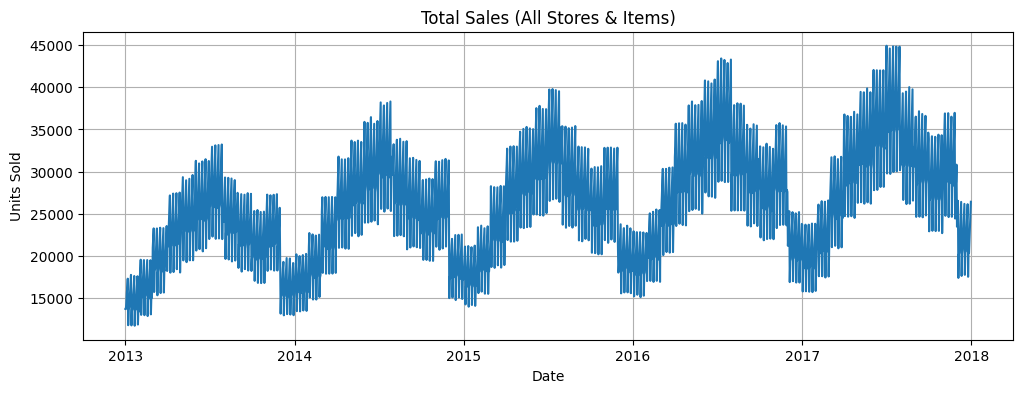

In [9]:
#plotting the total daily sales for each day
#shows the seasonal spikes / dips, and long term trend
daily_total = df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(daily_total['date'], daily_total['sales'])
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Total Sales (All Stores & Items)')
plt.grid(True)
plt.show()

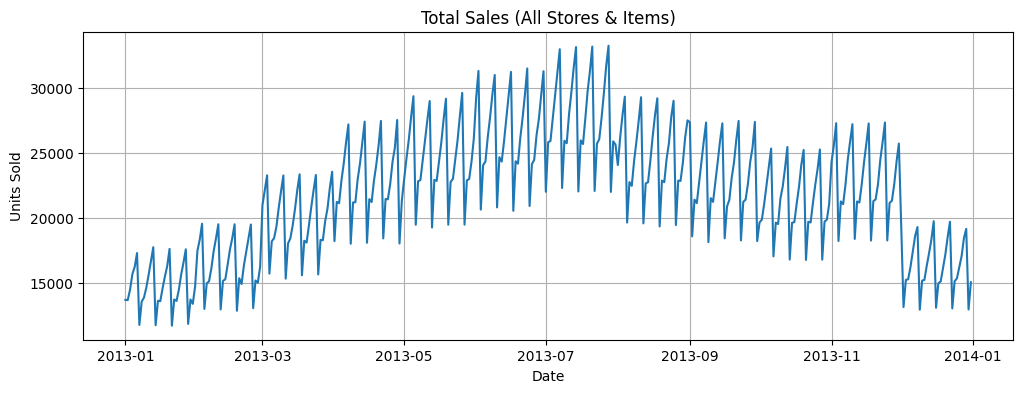

In [11]:
#zooming in on one year -> 2013
df_2013 = df[df['date'].dt.year == 2013]
daily_total_2013 = df_2013.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(daily_total_2013['date'], daily_total_2013['sales'])
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Total Sales (All Stores & Items)')
plt.grid(True)
plt.show()


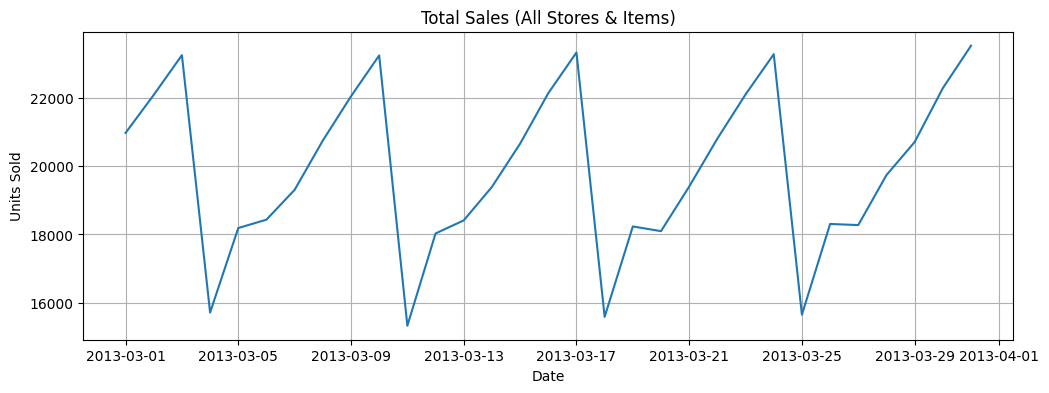

In [15]:
#zooming in on one month -> Mar 2013
df_2013 = df[(df['date'].dt.year == 2013) & (df['date'].dt.month == 3)]
daily_total_2013 = df_2013.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(daily_total_2013['date'], daily_total_2013['sales'])
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Total Sales (All Stores & Items)')
plt.grid(True)
plt.show()

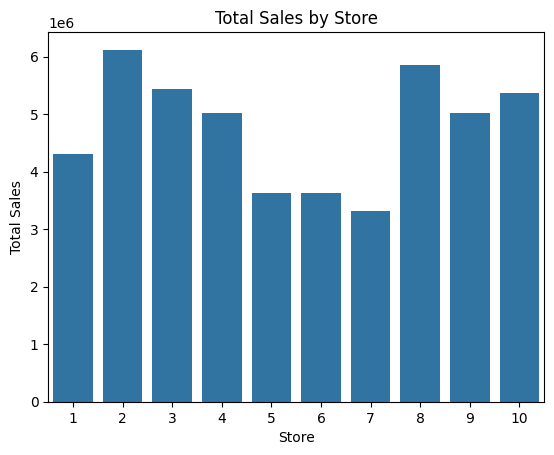

In [45]:
#show total sales by store over all 4 years
store_summary = df.groupby('store')['sales'].sum().sort_values()
sns.barplot(x=store_summary.index, y=store_summary.values)
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')
plt.show()

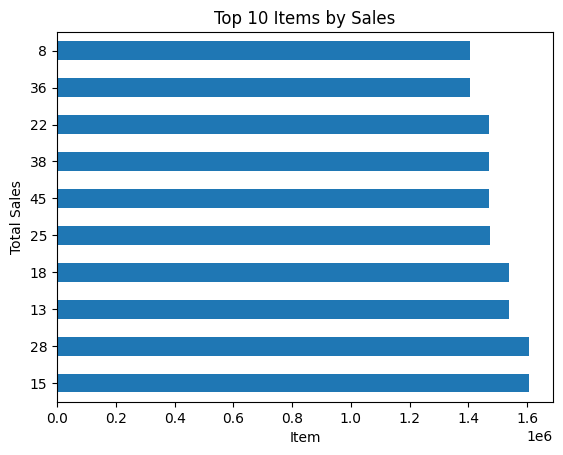

In [19]:
#plot top 10 selling items
item_summary = df.groupby('item')['sales'].sum().sort_values(ascending=False)
item_summary.head(10).plot(kind='barh')
plt.title('Top 10 Items by Sales')
plt.xlabel('Item')
plt.ylabel('Total Sales')
plt.show()

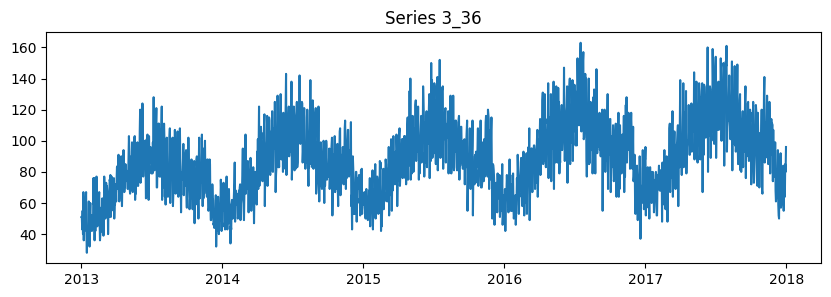

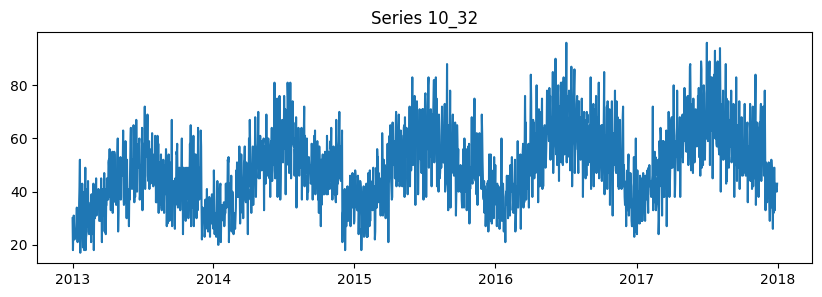

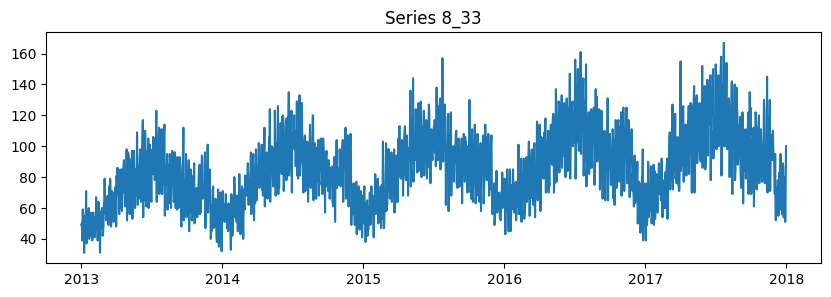

In [21]:
#plotting 3 random series of store/item combinations
sample_ids = np.random.choice(df['series_id'].unique(), 3, replace=False)
for sid in sample_ids:
  sub = df[df['series_id'] == sid]
  plt.figure(figsize=(10, 3))
  plt.plot(sub['date'], sub['sales'])
  plt.title(f"Series {sid}")
  plt.show()

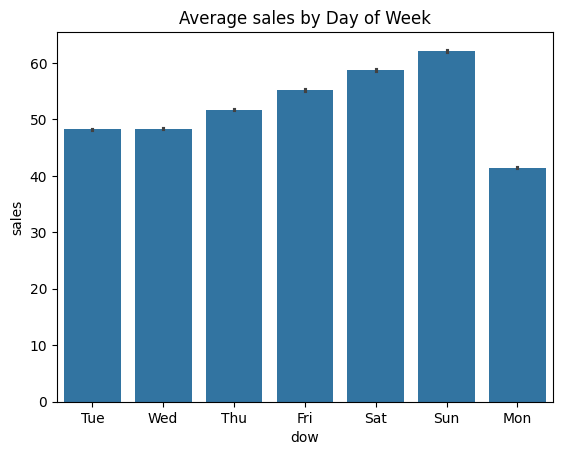

In [28]:
#plot the average sales by day of the week
dow = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['dow'] = df['date'].dt.dayofweek.apply(lambda x: dow[x])
sns.barplot(x='dow', y='sales', data=df)
plt.title("Average sales by Day of Week")
plt.show()

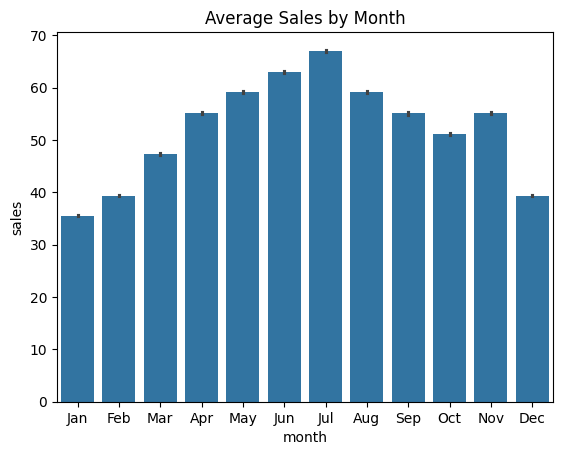

In [31]:
#get the average total sales by month
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month'] = df['date'].dt.month.apply(lambda x: month[x-1])
sns.barplot(x='month', y='sales', data=df)
plt.title("Average Sales by Month")
plt.show()

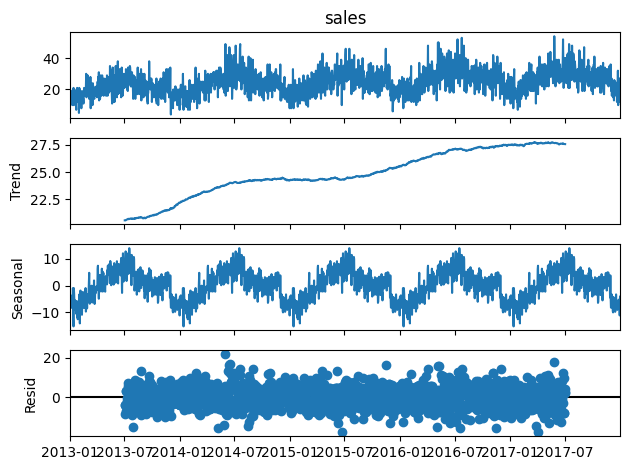

In [33]:
'''
Plot the seasonality, trends, and residuals
  Sales: original time series, raw sales over time
  Trend: long term trend. Are the sales increasing over time?
  Seasonal: repeating periodic patterns
  Residuals: random fluctuations, unpredictable stuff that hasn't yet been explained by the model
'''
from statsmodels.tsa.seasonal import seasonal_decompose
sample = df[df['series_id'] == df['series_id'].iloc[0]].set_index('date')
result = seasonal_decompose(sample['sales'], model='additive', period=365)
result.plot()
plt.show()

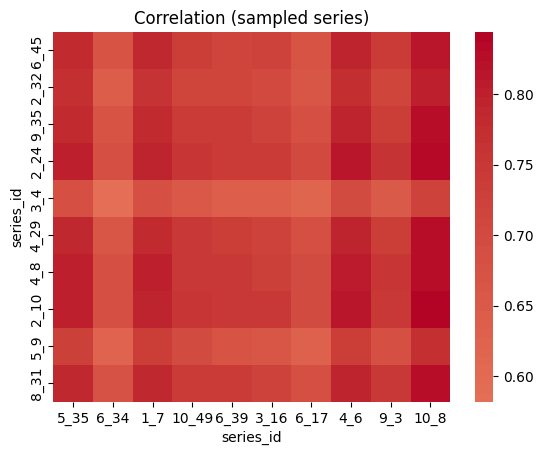

In [37]:
#show correlation between sample of 10 series id's
pivot = df.pivot_table(index='date', columns='series_id', values='sales')
corr = pivot.corr().sample(10, axis=0).sample(10, axis=1)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation (sampled series)')
plt.show()

# Summary
Dataset

*   Date Range: 01-01-2013 - 12-31-2017
*   Total samples: 913,000
* 500 unique series (store + item combinations)

Total Sales
* Peak: Jul
* Low: Jan / Dec
* Trend: Upward

Total Sales by Store
* Highest Sales: Store 2
* Lowest Sales: Store 7

Sales Per Week

* Highest: Sun
* Lowest: Mon